In [1]:
print("Jupyter is ready for CE40248")

Jupyter is ready for CE40248


Input -> Calculate forces and integrate equations of motion -> perform P, control T if necessary -> t = t + deltT -> Calculate and update the molecule position (-> t<tmax back to the calcualte forces tab) -> Output: key output is a trajectory file with positions at a given time, here the thermodynamics and transport properties are determined....

Sigma is the diameter of atom and epsilon is the energy of the particle

In order to control reaction in terms of energy, need to completely isolate the system. This is not physically 100% possible. Come with a theoretical limit. 

If try to determine a parameter, do not use the equilibration zone



In [1]:
import numpy as np

def U_LJ(r): # Function to calculate potential energy LJ
    return 4 * ((1/r)**12 - (1/r)**6) # Reduced LJ potential u*(r*) where r* = r/sigma and u* = U/epsilon

def F_LJ(r): # Function to calculate force magnitude
    return 24 * (2*(1/r)**12 - (1/r)**6) / r # Reduced LJ force magnitude f*(r*) where f* = sigma/epsilon*F


In [2]:
N = 10 # number of particles
L = 5.0 # box length (in reduced LJ units)
dt = 0.005 # reduced time step (dt* = 0.005)
nsteps = 2000 # number of integration steps, where dt=0.005tau and tau = sigma*sqrt(mass/epsilon)

np.random.seed(1) # Sets a random seed up
positions = np.random.rand(N, 3) * L # uniform initial positions, and then scaled by L to fit in the box properly (10 x 3 matrix)
velocities = np.random.randn(N, 3) # random velocities (normal distribution) (10 x 3 matrix)
velocities -= velocities.mean(axis=0) # remove centre-of-mass drift, subtracts from all velocities to ensure doesnt drift through space

In [3]:
rc = 2.5 # reduced cutoff (no tail corrections), take as theres no interactions when th distance between the particles is this long

def compute_forces(positions, rc=rc): # Function to determine the forces acting on each moleucle due to interaction
    N = positions.shape[0] 
    forces = np.zeros_like(positions) # Makes a matrix the same size as positions to get forces in each direction
    potential = 0.0 # Set the potential energy to 0
    
    for i in range(N - 1): # One less that the total number of particles (as each particle cannot interact with itself)
        for j in range(i + 1, N): # Works for all interactions between eevry particle
            rij = positions[i] - positions[j] # Distance between the compared particles (vector)
            r = np.linalg.norm(rij) # Finds the magnitude of the distance (Euclidian distance)
    
            # skip self/near-zero distances to avoid division by zero
            if r < 1e-12: # Will never get this close, unless randomly placed in same position
                continue
            if r < rc: # If below the cut of radius, the molecules will interact
                fij_mag = F_LJ(r) # reduced LJ force magnitude, calls the reduced LJ F funciton 
                fij_vec = fij_mag * (rij / r) # takes the magnitude of the forces and applies to all directions
                forces[i] += fij_vec # Adds the force vector to I
                forces[j] -= fij_vec # Subtracts the force vector from j as moves in opposite direction
                potential += U_LJ(r) # reduced pair potential
    return forces, potential

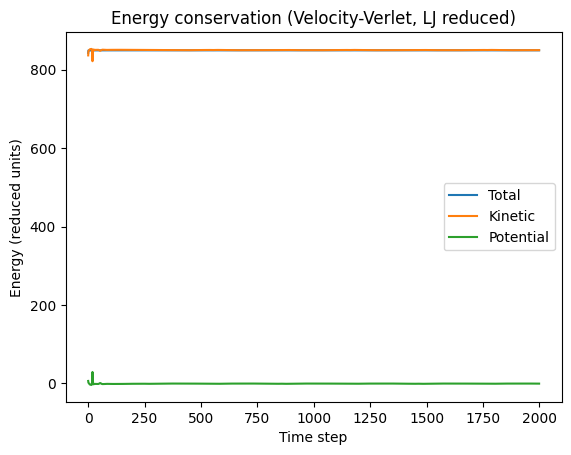

In [4]:
import matplotlib.pyplot as plt
# initial forces and potential
forces, pot = compute_forces(positions)

KE, PE, TE = [], [], [] # Lists to store energies
save_stride = 10 # only saves every 10th frame to reduce file size
traj = [] # list of snapshots for XYZ export

for step in range(nsteps): # Will fun for amount of steps (2000 originally)
    # Velocity-Verlet (m* = 1 => no division by mass)
    velocities += 0.5 * forces * dt # Originally the random value, F = ma (no m as reduced), need to account for m 
    positions += velocities * dt # Then update positions accordingly ue to timestep
    forces, pot = compute_forces(positions) # Call the compute forces again and recalculates
    velocities += 0.5 * forces * dt # As above...
    # energies in reduced units
    kin = 0.5 * np.sum(velocities**2) # m* = 1, from og kinetic equation, take into acount all particles
    KE.append(kin); PE.append(pot); TE.append(kin + pot)
    if step % save_stride == 0:
        traj.append(positions.copy()) # avoid aliasing

# ---- plot energies (reduced units) ----
plt.plot(TE, label='Total')
plt.plot(KE, label='Kinetic')
plt.plot(PE, label='Potential')
plt.xlabel('Time step')
plt.ylabel('Energy (reduced units)')
plt.title('Energy conservation (Velocity-Verlet, LJ reduced)')
plt.legend()
plt.show()

In [5]:
with open("traj.xyz", "w") as f: # creates a xyz file for visulaisation, overwrites if already made
    for k, frame in enumerate(traj): # list of position snap shots (10, 3) for every time step...
        step = k * save_stride # 
        f.write(f"{N}\nStep {step} (LJ reduced units, box L={L})\n")
        for x, y, z in frame:
            f.write(f"Ar {x:.6f} {y:.6f} {z:.6f}\n")


In [6]:
# ============================================
# Visualise Particle Dispersion from XYZ file
# using py3Dmol in Jupyter Notebook
# ============================================

# Step 1: Install py3Dmol if needed
!pip install py3Dmol

# Step 2: Import and load your .xyz file
import py3Dmol

# Replace this with your file name
filename = "traj.xyz"

with open(filename) as f:
    xyz_data = f.read()

# Step 3: Create viewer
view = py3Dmol.view(width=700, height=500)

# Add all XYZ frames as animation frames
view.addModelsAsFrames(xyz_data, 'xyz')

# Step 4: Style options
view.setStyle({'sphere': {'scale': 0.5, 'colorscheme': 'Jmol'}})  # spheres for particles
view.setBackgroundColor('white')
view.zoomTo()

# Step 5: Animation controls
# Adjust 'step' for speed; smaller = slower animation
view.animate({'loop': 'forward', 'reps': 0, 'step': 1})

# Step 6: Optional — draw a box to represent the simulation boundary
# If your XYZ doesn’t specify box dimensions, set them manually:
box_size = 10.0  # edit this to match your system dimensions

# Draw edges of a cubic box for context
edges = [
    [[0,0,0],[box_size,0,0]], [[0,0,0],[0,box_size,0]], [[0,0,0],[0,0,box_size]],
    [[box_size,box_size,0],[box_size,0,0]], [[box_size,box_size,0],[0,box_size,0]],
    [[box_size,0,box_size],[box_size,0,0]], [[box_size,0,box_size],[0,0,box_size]],
    [[0,box_size,box_size],[0,box_size,0]], [[0,box_size,box_size],[0,0,box_size]],
    [[box_size,box_size,box_size],[box_size,box_size,0]],
    [[box_size,box_size,box_size],[box_size,0,box_size]],
    [[box_size,box_size,box_size],[0,box_size,box_size]]
]

for edge in edges:
    view.addLine({'start': {'x': edge[0][0], 'y': edge[0][1], 'z': edge[0][2]},
                  'end': {'x': edge[1][0], 'y': edge[1][1], 'z': edge[1][2]},
                  'color': 'black', 'radius': 0.05})

view.show()


Defaulting to user installation because normal site-packages is not writeable


3Dmol.js failed to load for some reason. Please check your browser console for error messages.